In [1]:
!pip install -q tensorflow==2.15.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.9.1 requires tensorflow~=2.16.1, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-serving-api 2.16.1 requires tensorflow<3,>=2.16.1, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.15.0 which is incompatible.
tensorstore 0.1.66 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.16.0 requires tensorflow<2.17,>=2.16, but you have tensorflow 2.15.0 which is incompatible.


In [2]:
import os
import gc 
import random
import ctypes
from tqdm import tqdm
from collections import defaultdict

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image
import albumentations as albu

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score

import warnings 
warnings.filterwarnings('ignore')


## tensorflow version
import tensorflow as tf
from tensorflow.keras import layers, Model, losses, optimizers
import tensorflow.keras.backend as K

print('tensorflow version: ', tf.__version__)
os.environ['CUDA_IS_VISIBLE'] = '0,1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
    
LOAD_MODELS_FROM = None

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2024-10-15 00:52:01.961338: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 00:52:01.961400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 00:52:01.962900: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tensorflow version:  2.15.0
Using 2 GPUs


In [3]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

In [4]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(42)

In [5]:
MIX = True
if MIX: 
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else: 
    print('Using full precision')

Mixed Precision enabled


In [6]:
df_pc = pd.read_csv('/kaggle/input/pc-dataset/metadata.csv')
tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', 'pc-dataset','*','*', '*'))}    
    
df_pc['path'] = df_pc['Image Index'].map(tmp)
df_pc['Patient ID'] = 'pc_' + df_pc['Patient ID']
df_pc = df_pc[df_pc['Patient Age'] >= 16].reset_index(drop=True)

In [7]:
df_nih = pd.read_csv('/kaggle/input/nih-big-dataset/metadata.csv')
tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', 'nih-big-dataset','*','*'))}    
    
df_nih['path'] = df_nih['Image Index'].map(tmp)
    
df_nih['Patient ID'] = df_nih['Patient ID'].astype('string')
df_nih['Patient ID'] = 'nih_' + df_nih['Patient ID'] 
df_nih = df_nih[df_nih['Patient Age'] >= 16].reset_index(drop=True)

In [8]:
df = pd.concat([df_nih, df_pc])
df = df.reset_index(drop=True)

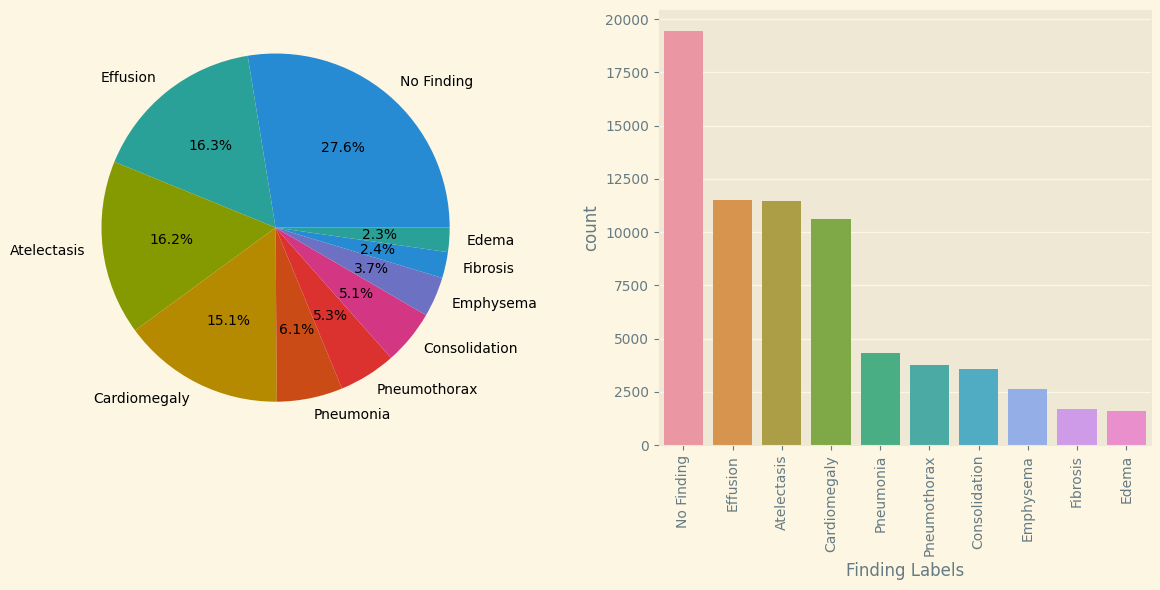

In [9]:
label_counts = df['Finding Labels'].str.split('|').explode().value_counts()

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].str.split('|').explode().value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'].str.split('|').explode(), order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [10]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [11]:
allowed_labels = ['No Finding', 'Cardiomegaly', 'Edema', 'Atelectasis', 'Pneumonia',
                  'Effusion', 'Pneumothorax', 'Emphysema', 'Consolidation', 'Fibrosis']

for label in allowed_labels:
    df_test[label] = df_test['Finding Labels'].apply(lambda x: 1.0 if label in x.split('|') else 0.0).astype('float32')
    df_train[label] = df_train['Finding Labels'].apply(lambda x: 1.0 if label in x.split('|') else 0.0).astype('float32')

TARGET = allowed_labels

In [12]:
TARGET

['No Finding',
 'Cardiomegaly',
 'Edema',
 'Atelectasis',
 'Pneumonia',
 'Effusion',
 'Pneumothorax',
 'Emphysema',
 'Consolidation',
 'Fibrosis']

In [13]:
import albumentations as albu
print(albu.__version__)

1.4.17


In [14]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, augment1=False, augment2=False, preprocess=None):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment1 = augment1
        self.augment2 = augment2
        self.on_epoch_end()
        self.preprocess = preprocess
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

        
    def __len__(self):
        
        # Drop_Last = False
        ct = int(np.ceil(len(self.data)/self.batch_size))
        return ct
    
    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.augment1: X = self.__augment1(X)
        if self.augment2: X = self.__augment2(X)
        if self.preprocess != None: X = self.preprocess(X)
        return X,y
    
    def on_epoch_end(self,):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)
        
    def __data_generation(self, indexes):
        
        X = np.zeros((len(indexes),256,256,3), dtype='float32') 
        y = np.zeros((len(indexes),len(TARGET)), dtype='float32')
        
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']
            
            if np.array(Image.open(path)).dtype == np.uint16:
                img = np.array(Image.open(path))
                img = (img / 65536.0 * 255).astype(np.uint8)
                img = Image.fromarray(img)
                img = img.resize((256, 256), Image.Resampling.LANCZOS)
                img = np.array(img)
                img = img.astype(np.uint8)
                img = self.clahe.apply(img)
                img = np.expand_dims(img, axis=-1)
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            else: 
                img = Image.open(path).convert('L')
                img = img.resize((256,256), Image.Resampling.LANCZOS)
                img = np.array(img) 
            
                img = self.clahe.apply(img) 
                img = np.expand_dims(img, axis=-1)  
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) 
            
            # FillNaN
            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)
            
            
            X[j,:,:,:3] = img
            y[j,] = row[TARGET]
            
        return X,y
            
    
    def __augment1(self, img_batch):
        
        composition = albu.Compose([
                 albu.OneOf([albu.HorizontalFlip(p=1.0)], p=0.5),
                 albu.OneOf([albu.Rotate(limit=5, p=1.0)], p=0.5),
        ])
        
        for i in range(img_batch.shape[0]):
            img = composition(image=img_batch[i,])['image']
                
            img_batch[i,] = img
            
            
        return img_batch
    
    
    def __augment2(self, img_batch,cutmix_prob=0.5, num_patches=2):
        batch_size, height, width, channels = img_batch.shape

        for i in range(batch_size):
            if np.random.rand() <= cutmix_prob:  
                for _ in range(num_patches):  # 여러 개의 패치를 적용하기 위해 반복문 추가
                    idx = np.random.randint(batch_size)
                    lam = np.random.beta(2.0, 2.0)
         
                    cut_width = min(int(width * lam), width//5)
                    cut_height = min(int(height * lam), height//5)
                    cut_x = np.random.randint(0, width - cut_width + 1)
                    cut_y = np.random.randint(0, height - cut_height + 1)

                    img_batch[i, cut_y:cut_y + cut_height, cut_x:cut_x + cut_width, :] = img_batch[idx, cut_y:cut_y + cut_height, cut_x:cut_x + cut_width, :]
            
        return img_batch

In [15]:
!pip install -q -U git+https://github.com/qubvel/efficientnet
    
import efficientnet.tfkeras as efn

In [16]:
!pip install -q tfimm

import tfimm

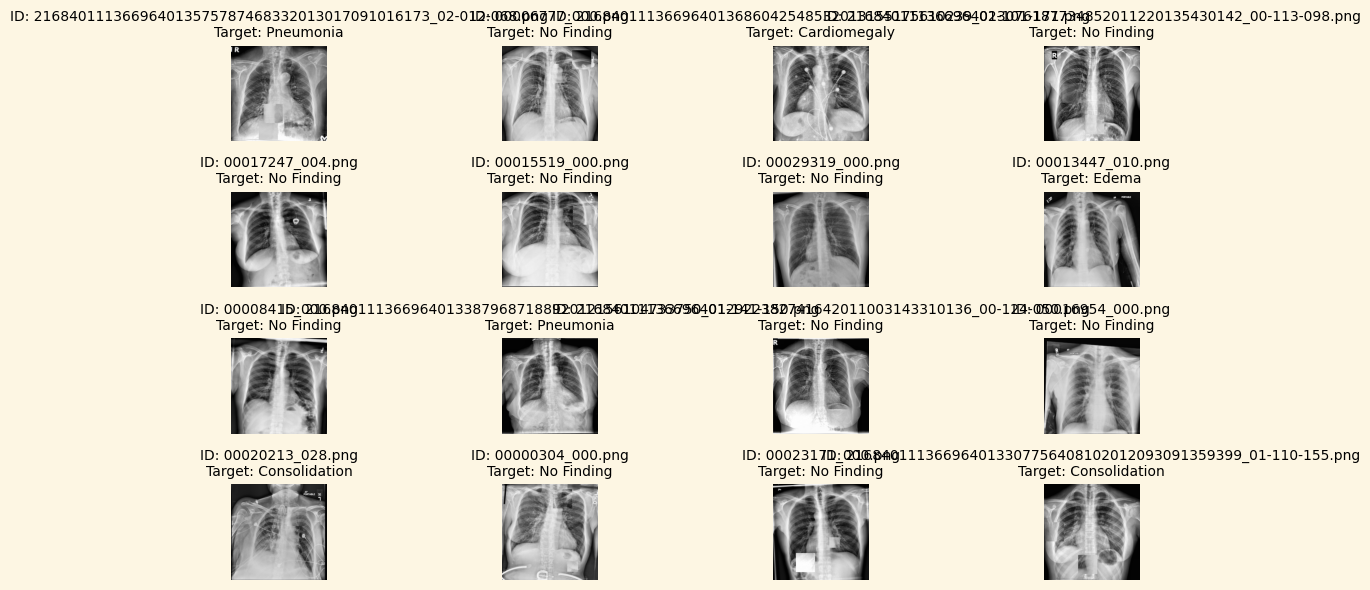

In [17]:
ROWS = 4; COLS = 4; BATCHES = 1


gen = DataGenerator(df_train,batch_size=16, shuffle=False, augment1=True, augment2=True, preprocess=None)

for i, (x,y) in enumerate(gen):
    plt.figure(figsize=(12,6))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            img_id = df_train.iloc[i*16+j*COLS+k]['Image Index']
            plt.title(f'ID: {img_id}\nTarget: {df_train.iloc[i*16+j*COLS+k]["Finding Labels"]}', size=10)
            img = x[j*COLS+k,:,:,:3]
            img = img.astype('uint8')
            plt.imshow(img)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    if i==BATCHES-1: break

In [18]:
class MultiAtrous(tf.keras.Model):
    def __init__(self,
                 dilation_rates=[4, 8, 12],
                  kernel_size=3,
                  upsampling =1,
                  padding='same', **kwargs):
        super().__init__(name='MultiAtrous', **kwargs)
        self.dilation_rates = dilation_rates
        self.kernel_size = kernel_size
        self.padding = padding
        self.upsampling = upsampling
        
        # Dilated Convolutions
        self.dilated_convs = [
            layers.Conv2D(
               filters = int(640 / 4),
               kernel_size = self.kernel_size,
               padding = self.padding,
               dilation_rate = rate,
            ) for rate in self.dilation_rates
            
        ]
        
        # Global Average Pooling(GAP)
        self.gap_branch = tf.keras.Sequential(
           [
               layers.GlobalAveragePooling2D(keepdims=True),
               layers.Conv2D(int(640/2), kernel_size=1),
               layers.Activation('relu'),
               layers.UpSampling2D(size=self.upsampling, interpolation='bilinear')
           ], name='gap_branch'
        )
        
    def call(self, inputs, training=None, **kwargs):
        local_feature = []
            
        for dilated_conv in self.dilated_convs:
            x = dilated_conv(inputs)
            x = self.gap_branch(x)
            local_feature.append(x)
                
        return tf.concat(local_feature, axis=-1)
    
class LocalBranch(tf.keras.Model):
    def __init__(self,IMG_SIZE, **kwargs):
        super().__init__(name='LocalBranch', **kwargs)
        self.multi_atrous = MultiAtrous(padding='same', upsampling=int(IMG_SIZE/32))
        self.conv1 = layers.Conv2D(640, kernel_size=1)
        self.conv2 = layers.Conv2D(640, kernel_size=1, use_bias=False)
        self.conv3 = layers.Conv2D(640, kernel_size=1)
        self.bn = layers.BatchNormalization()
        
    def call(self, inputs, training=None, **kwargs):
        local_feat = self.multi_atrous(inputs)
        local_feat = self.conv1(local_feat)
        local_feat = layers.ReLU()(local_feat)
        
        ## self attention
        local_feat = self.conv2(local_feat)
        local_feat = self.bn(local_feat)
        
        # l-2 norms
        norm_local_feat = tf.math.l2_normalize(local_feat)
        
        attn_map = layers.ReLU()(local_feat)
        attn_map = self.conv3(attn_map)
        attn_map = tf.keras.activations.softplus(attn_map)
        
        return norm_local_feat * attn_map

In [19]:
class OrthogonalFusion(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(name='OrthogonalFusion', **kwargs)
    def call(self, inputs):
        local_feat, global_feat = inputs
        height = local_feat.shape[1]
        width  = local_feat.shape[2]
        depth  = local_feat.shape[3]
    
        local_feat = tf.reshape(local_feat, [-1, height*width, depth])
        local_feat = tf.transpose(local_feat, perm=[0, 2, 1])
        
        projection = tf.matmul(
            tf.expand_dims(global_feat, axis=1), 
            local_feat
        )
        projection = tf.matmul(
            tf.expand_dims(global_feat, axis=2),
            projection
        )
        projection = tf.reshape(projection, [-1, height, width, depth])
        
        global_feat_norm = tf.norm(global_feat, ord=2, axis=1)  
        projection = projection / tf.reshape(global_feat_norm*global_feat_norm, shape=[-1, 1, 1, 1])
        local_feat = tf.transpose(local_feat, perm=[0, 1, 2])
        local_feat = tf.reshape(local_feat, [-1, height, width, depth])
    
        orthogonal_comp = local_feat - projection
        global_feat = tf.expand_dims(tf.expand_dims(global_feat, axis=1), axis=1)
        global_feat = tf.broadcast_to(global_feat, tf.shape(local_feat))
        output = tf.concat([global_feat, orthogonal_comp], axis=-1)
        return output

In [20]:
class CAM(layers.Layer):
    def __init__(self, ratio=8):
        super().__init__()
        self.ratio = ratio
        self.gap = layers.GlobalAveragePooling2D()
        self.gmp = layers.GlobalMaxPooling2D()

    def build(self, input_shape):
        self.conv1 = layers.Conv2D(input_shape[-1]//self.ratio,
                                   kernel_size=1,
                                   strides=1, padding='same',
                                   activation='relu')
        self.conv2 = layers.Conv2D(input_shape[-1],
                                   kernel_size=1,
                                   strides=1, padding='same',
                                   activation='relu')

    def call(self, inputs):
        gap = self.gap(inputs)
        gmp = self.gmp(inputs)
        gap = layers.Reshape((1,1,gap.shape[1]))(gap)
        gmp = layers.Reshape((1,1,gmp.shape[1]))(gmp)
        gap_out = self.conv2(self.conv1(gap))
        gmp_out = self.conv2(self.conv1(gmp))

        return tf.math.sigmoid(gap_out+gmp_out)
     


class SAM(layers.Layer):
    def __init__(self, kernel_size=3):
        super().__init__()
        self.conv1 = layers.Conv2D(64,
                                            kernel_size=kernel_size,
                                            use_bias=False,
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same',
                                            activation=tf.nn.relu)
        self.conv2 = layers.Conv2D(32, kernel_size=kernel_size,
                                            use_bias=False,
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same',
                                            activation=tf.nn.relu)
        self.conv3 = layers.Conv2D(16, kernel_size=kernel_size,
                                            use_bias=False,
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same',
                                            activation=tf.nn.relu)
        self.conv4 = layers.Conv2D(1,
                                            kernel_size=(1, 1),
                                            use_bias=False,
                                            kernel_initializer='he_normal',
                                            strides=1, padding='same',
                                            activation=tf.math.sigmoid)


    def call(self, inputs):
        avg_out = tf.reduce_mean(inputs, axis=3)
        max_out = tf.reduce_max(inputs,  axis=3)
        x = tf.stack([avg_out, max_out], axis=3)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return self.conv4(x)


In [21]:
def build_model():
    inp = layers.Input(shape=(256,256,3))
    eff_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=(256,256,3))
    eff_model.load_weights('/kaggle/input/tf-efficientnet-noisy-student-weights/efficientnet-b0_noisy-student_notop.h5')
    cait_model = tfimm.create_model('cait_s24_224', in_channels=3, nb_classes=0, pretrained=True, 
                                     input_size=(256,256))
    dolg_model = Model(inputs=eff_model.input, 
                      outputs=[eff_model.get_layer('block5c_add').output, eff_model.get_layer('block7a_project_bn').output])
    
    orthogonal_fusion = OrthogonalFusion()
    local_branch = LocalBranch(IMG_SIZE=256)
    global_branch_pool = tf.keras.Sequential([
        layers.GlobalAveragePooling2D(),
        layers.Dense(640, activation=None)
    ], name = 'GlobalBranchPooling')
    
    local_feat, global_feat = dolg_model(inp)
    global_feat = CAM()(global_feat)*global_feat
    local_feat = local_branch(local_feat)
    global_feat = global_branch_pool(global_feat)
    orthogonal_feat = orthogonal_fusion([local_feat, global_feat])
    eff_out = layers.GlobalAveragePooling2D()(orthogonal_feat)
    
    
    cait_out = cait_model(inp)
    cait_out = layers.RepeatVector(5)(cait_out)
    
    cait_out = layers.Bidirectional(
               layers.LSTM(cait_out.shape[-1]//2, return_sequences=False)
    )(cait_out)
    
    out = layers.Concatenate(axis=-1)([cait_out, eff_out])
    
    
    x = layers.Dense(len(TARGET), activation='sigmoid', dtype='float32')(out)
    
    # Compile
    model = Model(inputs=inp, outputs=x)
    loss = losses.BinaryCrossentropy(label_smoothing=0.05)
    opt = optimizers.Adam(learning_rate=1e-3)
    label_weights = [1.0] * len(TARGET)
    AUC = tf.keras.metrics.AUC(name='auc', label_weights=label_weights)
    
    model.compile(loss=loss, optimizer=opt, metrics=[AUC])
    
    return model

In [22]:
from tensorflow.keras.utils import plot_model
K.clear_session()
model = build_model()
model.summary()

#plot_model(model, show_shapes=True, show_layer_names=True)

model.safetensors:   0%|          | 0.00/188M [00:00<?, ?B/s]

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 16, 16, 112),        3634844   ['input_1[0][0]']             
                              (None, 8, 8, 320)]                                                  
                                                                                                  
 cam (CAM)                   (None, 1, 1, 320)            25960     ['model[0][1]']               
                                                                                                  
 tf.math.multiply (TFOpLamb  (None, 8, 8, 320)            0         ['cam[0][0]',           

In [23]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping 

EPOCHS = 10

es = EarlyStopping(monitor='val_auc', mode='max', patience=5)
lr = ReduceLROnPlateau(monitor = 'val_auc', factor = 0.1, patience = 1, min_delta = 0.01,
                              mode='max',verbose=1)

In [24]:
gkf = GroupKFold(n_splits=5)
for i, (_, valid_index) in enumerate(gkf.split(df_train, groups=df_train['Patient ID'])):
    df_train.loc[valid_index, 'Fold'] = i

In [25]:
import tensorflow.keras.backend as K

all_oof = []
all_true = []
all_index = []
all_history = defaultdict(list)

for i in range(1):
    
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(df_train[df_train['Fold'] != i], shuffle=True, augment1=True, augment2=True, batch_size=32, preprocess=efn.preprocess_input)
    valid_gen = DataGenerator(df_train[df_train['Fold'] == i], shuffle=False, batch_size=64, preprocess=efn.preprocess_input)
    
    print(f'### train size {len(df_train[df_train["Fold"] != i])}, valid size {len(df_train[df_train["Fold"] == i])}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = build_model()
    if LOAD_MODELS_FROM is None:
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        model.save_weights(f'Hybrid_f{i}.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])
        all_history['Valid Auc'].append(history.history['val_auc'])
        all_history['Train Auc'].append(history.history['auc'])

    else:
        model.load_weights(f'{LOAD_MODELS_FROM}Hybrid_f{i}.weights.h5')
        
    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(df_train[df_train['Fold'] == i][TARGET].values)
    all_index.append(df_train[df_train['Fold'] == i]['Image Index'].values)
    
    
    del model, oof, train_gen, valid_gen
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)
all_index = np.concatenate(all_index)

#########################
### Fold 1
### train size 38220, valid size 9555
#########################
Epoch 1/10


I0000 00:00:1728953852.710053      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1195/1195 [==============================] - 2191s 2s/step - loss: 0.3081 - auc: 0.8695 - val_loss: 0.6517 - val_auc: 0.3393 - lr: 0.0010
Epoch 2/10
1195/1195 [==============================] - 1482s 1s/step - loss: 0.3005 - auc: 0.8799 - val_loss: 5.2826 - val_auc: 0.5320 - lr: 0.0010
Epoch 3/10
1195/1195 [==============================] - ETA: 0s - loss: 0.2991 - auc: 0.8815
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1195/1195 [==============================] - 1483s 1s/step - loss: 0.2991 - auc: 0.8815 - val_loss: 3.0839 - val_auc: 0.5008 - lr: 0.0010
Epoch 4/10
1195/1195 [==============================] - 1478s 1s/step - loss: 0.2861 - auc: 0.9004 - val_loss: 0.2806 - val_auc: 0.9077 - lr: 1.0000e-04
Epoch 5/10
1195/1195 [==============================] - ETA: 0s - loss: 0.2836 - auc: 0.9036
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1195/1195 [==============================] - 1484s 1s/step - loss: 0.2836 - auc: 0

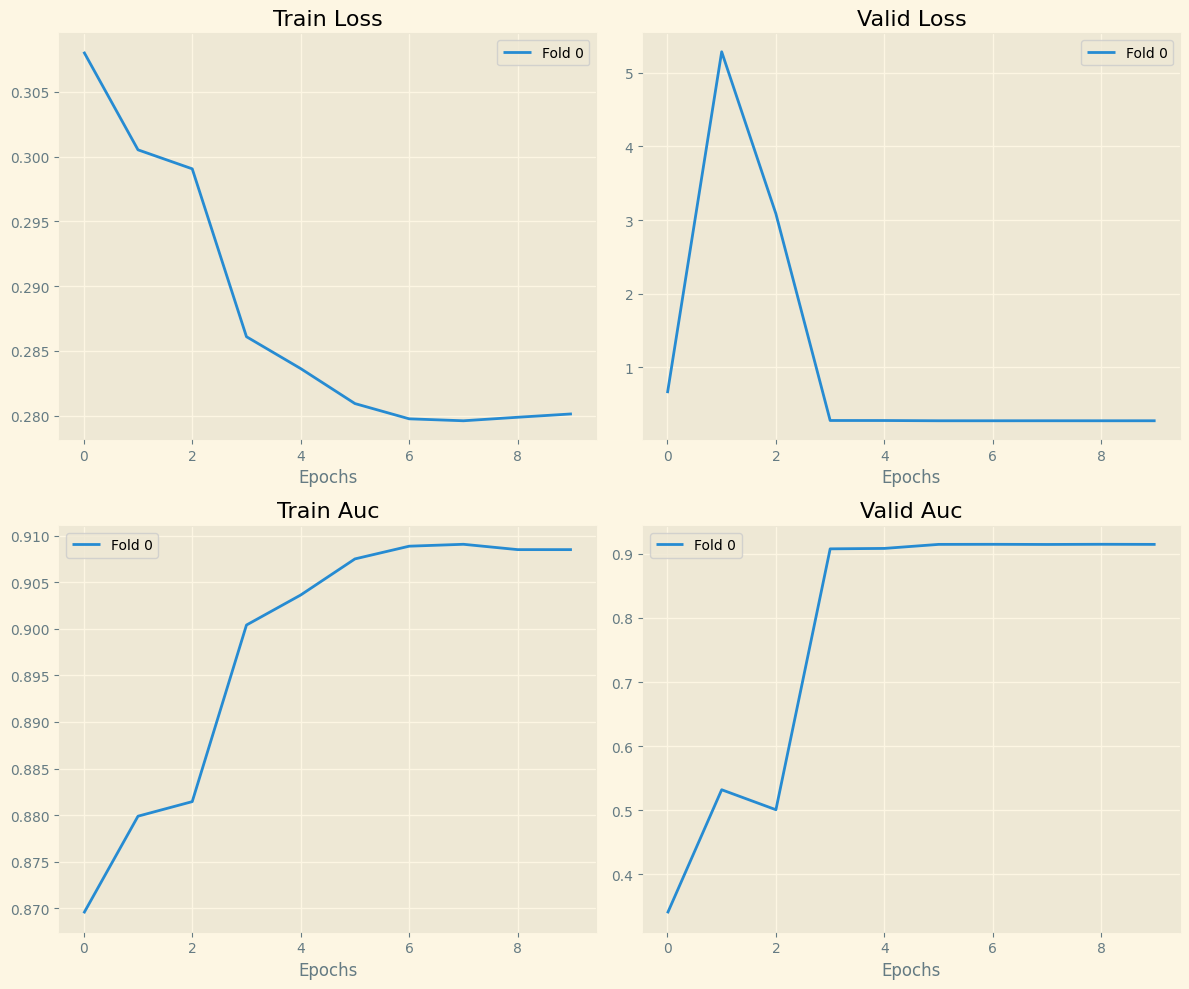

In [26]:
if LOAD_MODELS_FROM is None:
    plt.figure(figsize=(12,10))
    plt.subplot(2,2,1)
    plt.title('Train Loss')
    for fold, i in enumerate(all_history['Train Loss']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,2,2)
    plt.title('Valid Loss')
    for fold, i in enumerate(all_history['Valid Loss']):
        plt.plot(i,label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,2,3)
    plt.title('Train Auc')
    for fold, i in enumerate(all_history['Train Auc']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()
    
    plt.subplot(2,2,4)
    plt.title('Valid Auc')
    for fold, i in enumerate(all_history['Valid Auc']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()


    
    plt.tight_layout()
    plt.show()

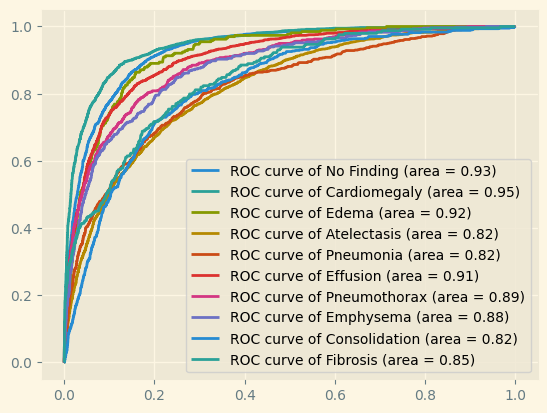

In [27]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(TARGET)):
    fpr[i], tpr[i], _ = roc_curve(all_true[:, i], all_oof[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()

In [28]:
auc_score = roc_auc_score(all_true, all_oof, average='macro', multi_class='ovr')  # 'ovr'은 one-vs-rest 방식
print('AUC for Train Set =', auc_score)

AUC for Train Set = 0.8767571441295869


In [29]:
preds = []
model = build_model()

## No TTA
test_gen = DataGenerator(df_test, shuffle=False, batch_size=128, preprocess=efn.preprocess_input)

for i in range(1):
    print(f'Fold {i+1}') 
    K.clear_session()
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}Hybrid_f{i}.weights.h5')
    else: 
        model.load_weights(f'Hybrid_f{i}.weights.h5')
    
    pred = model.predict(test_gen, verbose=1) 
    
preds.append(pred)
pred_res = np.mean(preds,axis=0)
    

auc_score = roc_auc_score(df_test[TARGET], pred_res, average='macro', multi_class='ovr')  # 'ovr'은 one-vs-rest 방식
print('AUC for Test Set =', auc_score)

Fold 1
94/94 [==============================] - 600s 6s/step
AUC for Test Set = 0.8805676056257955


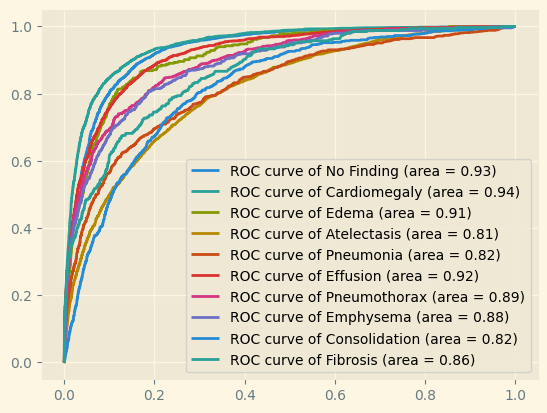

In [30]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(TARGET)):
    fpr[i], tpr[i], _ = roc_curve(df_test[TARGET[i]], pred_res[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()